# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMDB movie reviews with polarity labeling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

# Data Description

The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).
<br>

**Here's the description of the selected fields:**

review: the review text

pos: the target, '0' for negative and '1' for positive

ds_part: 'train'/'test' for the train/test part of dataset, correspondingly

 # **Attention! Running BERT! in this Project** 

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Load Data

In [5]:
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
    
print('Data been import correct')

Data been import correct


In [6]:
# function to calculate the percentage of missing values
def missing_values_table(df):
    """
    This function calculates the percentage of
    missing values in the dataset
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# Checking 0's
def zero_check(df):
    for i in df:
        print(i,len(df[df[i]==0]))
        
# function to determine if columns in file have null values        
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('{} has {} nulls, which is {:.{}%} percent of Nulls'.format(column, num_of_nulls, percent, num))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")       
        
# function to display general information about the dataset
def general_info(df):
    print("\033[1m" + "\033[0m")
    display(pd.concat([df.dtypes, df.count(),df.isna().sum(),df.isna().sum()/len(df)], keys=['type','count','na','na%'],
                      axis=1))
    print()
    print("\033[1m" + 'Head:')  
    display(df.head())
    print()
    print("\033[1m" + 'Tail:')
    display(df.tail())
    print()
    print("\033[1m" + 'Info:')
    print()
    display(df.info())
    print()
    print("\033[1m" + 'Describe:')
    print()
    display(df.describe())
    print()
    print("\033[1m" + 'Describe include: all :')
    print()
    display(df.describe(include='all'))
    print()
    print("\033[1m" + 'nulls in the columns:')
    print()
    display(get_percent_of_na(df, 4))  # check this out
    print()
    print("\033[1m" + 'Zeros in the columns:') 
    print()
    display(zero_check(df))
    print()
    print("\033[1m" + 'Shape:', df.shape)
    print()
    print()
    print('Duplicated:',"\033[1m" + 'We have {} duplicated rows\n'.format(df.duplicated().sum()) + "\033[0m")
    print()
    print("\033[1m" + 'Dtypes:')  
    display(df.dtypes)
    print()

In [7]:
#print our info data
print('information about Our dataset:')
general_info(df_reviews)

information about Our dataset:



,type,count,na,na%
tconst,object,47331,0,0.000000
title_type,object,47331,0,0.000000
primary_title,object,47331,0,0.000000
original_title,object,47331,0,0.000000
start_year,int64,47331,0,0.000000
end_year,object,47331,0,0.000000
runtime_minutes,object,47331,0,0.000000
is_adult,int64,47331,0,0.000000
genres,object,47331,0,0.000000
average_rating,float64,47329,2,0.000042



Head:


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281



Tail:


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164
47330,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,I'll make this brief. This was a joy to watch....,10,pos,1,test,4165



Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: I

None


Describe:



,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000



Describe include: all :



,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
count,47331,47331,47331,47331,47331.000000,47331,47331,47331.000000,47331,47329.000000,4.732900e+04,47331,47331.000000,47331,47331.000000,47331,47331.000000
unique,6648,10,6555,6562,NaN,60,249,NaN,585,NaN,NaN,47240,NaN,2,NaN,2,NaN
top,tt0120786,movie,The Sentinel,The Sentinel,NaN,\N,90,NaN,Drama,NaN,NaN,Loved today's show!!! It was a variety and not...,NaN,neg,NaN,train,NaN
freq,30,36861,60,60,NaN,45052,2442,NaN,3392,NaN,NaN,5,NaN,23715,NaN,23796,NaN
mean,NaN,NaN,NaN,NaN,1989.631235,NaN,NaN,0.001732,NaN,5.998278,2.556292e+04,NaN,5.484608,NaN,0.498954,NaN,6279.697999
std,NaN,NaN,NaN,NaN,19.600364,NaN,NaN,0.041587,NaN,1.494289,8.367004e+04,NaN,3.473109,NaN,0.500004,NaN,3605.702545
min,NaN,NaN,NaN,NaN,1894.000000,NaN,NaN,0.000000,NaN,1.400000,9.000000e+00,NaN,1.000000,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,1982.000000,NaN,NaN,0.000000,NaN,5.100000,8.270000e+02,NaN,2.000000,NaN,0.000000,NaN,3162.000000
50%,NaN,NaN,NaN,NaN,1998.000000,NaN,NaN,0.000000,NaN,6.300000,3.197000e+03,NaN,4.000000,NaN,0.000000,NaN,6299.000000
75%,NaN,NaN,NaN,NaN,2004.000000,NaN,NaN,0.000000,NaN,7.100000,1.397400e+04,NaN,9.000000,NaN,1.000000,NaN,9412.000000



nulls in the columns:

average_rating has 2 nulls, which is 0.0042% percent of Nulls
votes has 2 nulls, which is 0.0042% percent of Nulls
There are 2 columns with NA.


None


Zeros in the columns:

tconst 0
title_type 0
primary_title 0
original_title 0
start_year 0
end_year 0
runtime_minutes 0
is_adult 47249
genres 0
average_rating 0
votes 0
review 0
rating 0
sp 0
pos 23715
ds_part 0
idx 4


None


Shape: (47331, 17)


Duplicated: We have 0 duplicated rows


Dtypes:


tconst              object
title_type          object
primary_title       object
original_title      object
start_year           int64
end_year            object
runtime_minutes     object
is_adult             int64
genres              object
average_rating     float64
votes                Int64
review              object
rating               int64
sp                  object
pos                  int64
ds_part             object
idx                  int64
dtype: object

In [8]:
#Remove the missing values that we have in our dataset
df_reviews =df_reviews.dropna()

#Check or dropna result
missing_values_table(df_reviews)

,Missing Values,% of Total Values


<hr><b style="font-size: 20px;">Intermediate conclusion:</b>

- Our data set contains 47,331 rows and 17 columns


- We have 4 missing values split into two columns average_rating and votes ,     which we drop


- No duplicated rows


- We have reviews is from 1894 until 2010, when the highes peak is 2007


- lowest rating avg is 1.4 the highest is 9.7 when the score is from 1-10

## EDA

Let's check the number of movies and reviews over years.

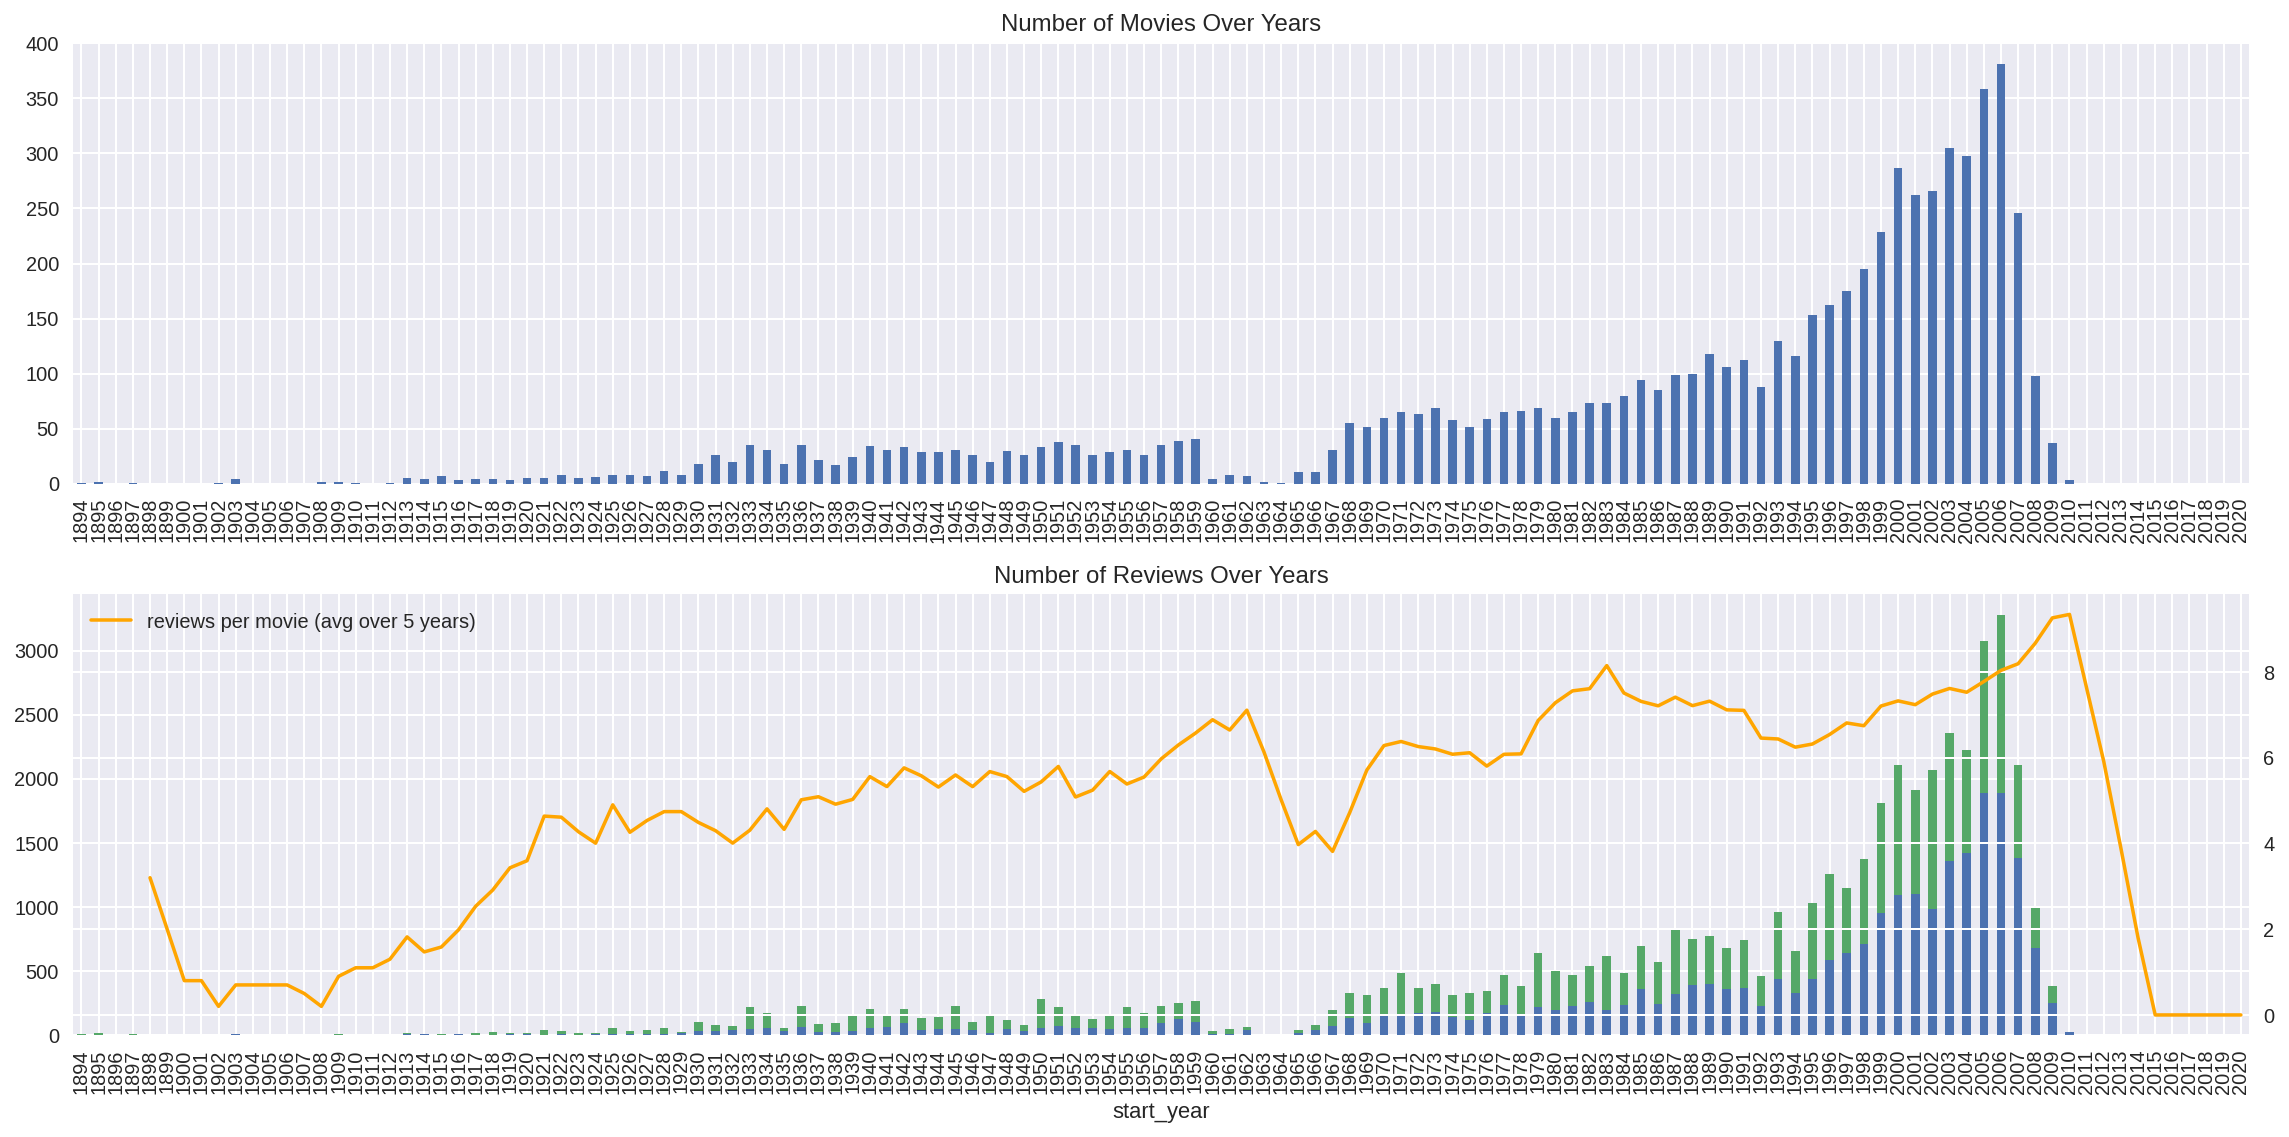

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

<b style="font-size: 20px;">Intermediate conclusion:</b>

We can see correlated between the amount of reviews to the movies been out to the public when our highest peak is 2007 , than is go down when our last review is 2010, this can be explain by the financial crisis in 2007 that may effect this industry years later. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

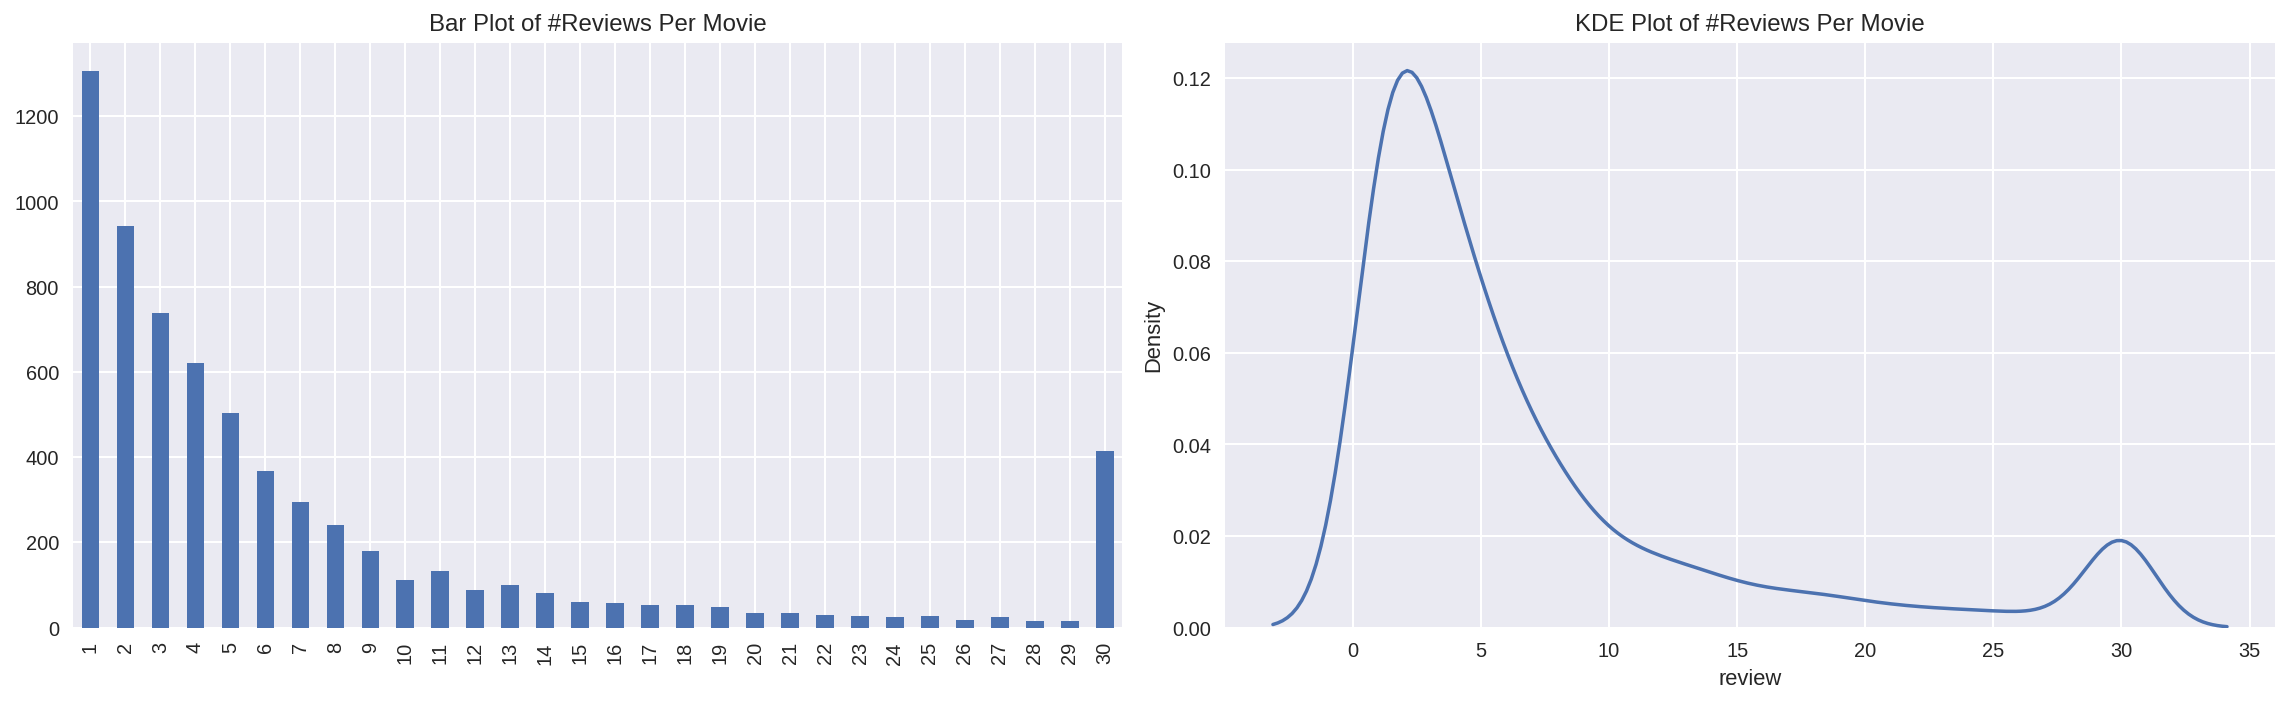

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [11]:
mr = df_reviews.groupby(['tconst','rating'])['review'].count().reset_index()
mr = mr.sort_values('review',ascending=False)
mr.head(20)

,tconst,rating,review
16874,tt0472047,1,30
16679,tt0463392,1,30
3304,tt0071075,10,30
16363,tt0451109,1,28
4866,tt0085474,10,27
5816,tt0093142,1,26
10607,tt0184424,10,26
13228,tt0312528,1,26
13351,tt0317676,1,25
10925,tt0201290,1,25


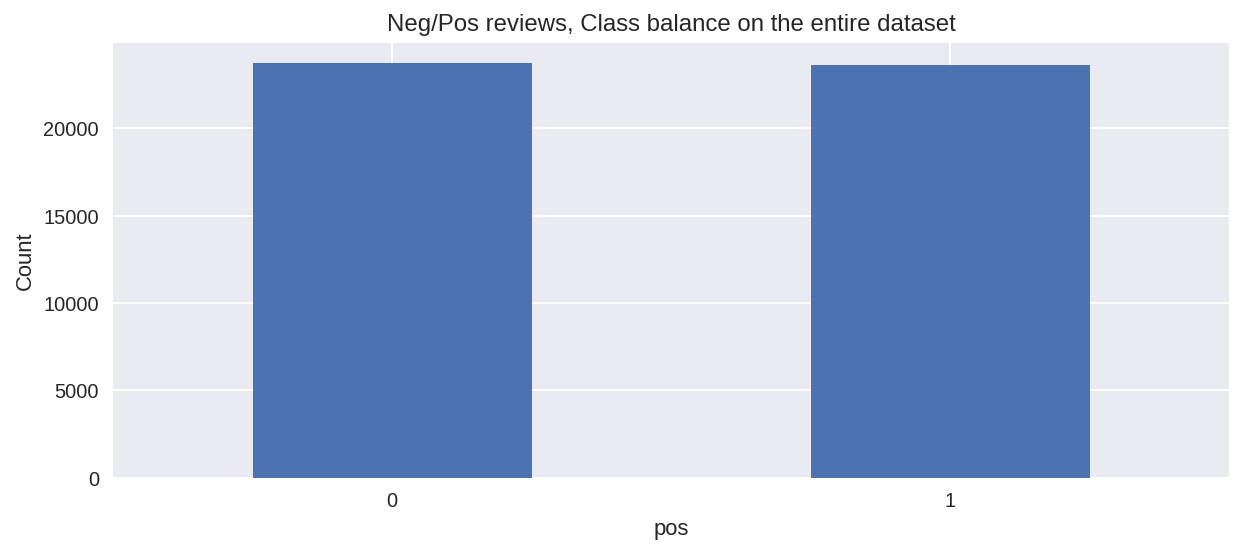

In [12]:
#Plot target 
count_target = pd.value_counts(df_reviews.pos, sort=True)
plt.figure(figsize=(10,4))
count_target.plot(kind='bar', rot=0)
plt.title('Neg/Pos reviews, Class balance on the entire dataset')
plt.xlabel('pos')
plt.ylabel('Count')
plt.show();

<b style="font-size: 20px;">Intermediate conclusion:</b>

It's seems like there is logical distribution in our data between negative and positive reviews, we also see many movies with lower rating with many reviews this can be explain amazing publicity for movie that finally arrive was only ok not more than that, this movies on top bring outlier of 30 reviews.

Also we can see that our viewer rating 1 or 10 and very very few gets score in between (like 'tt0274509' which got '2').

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

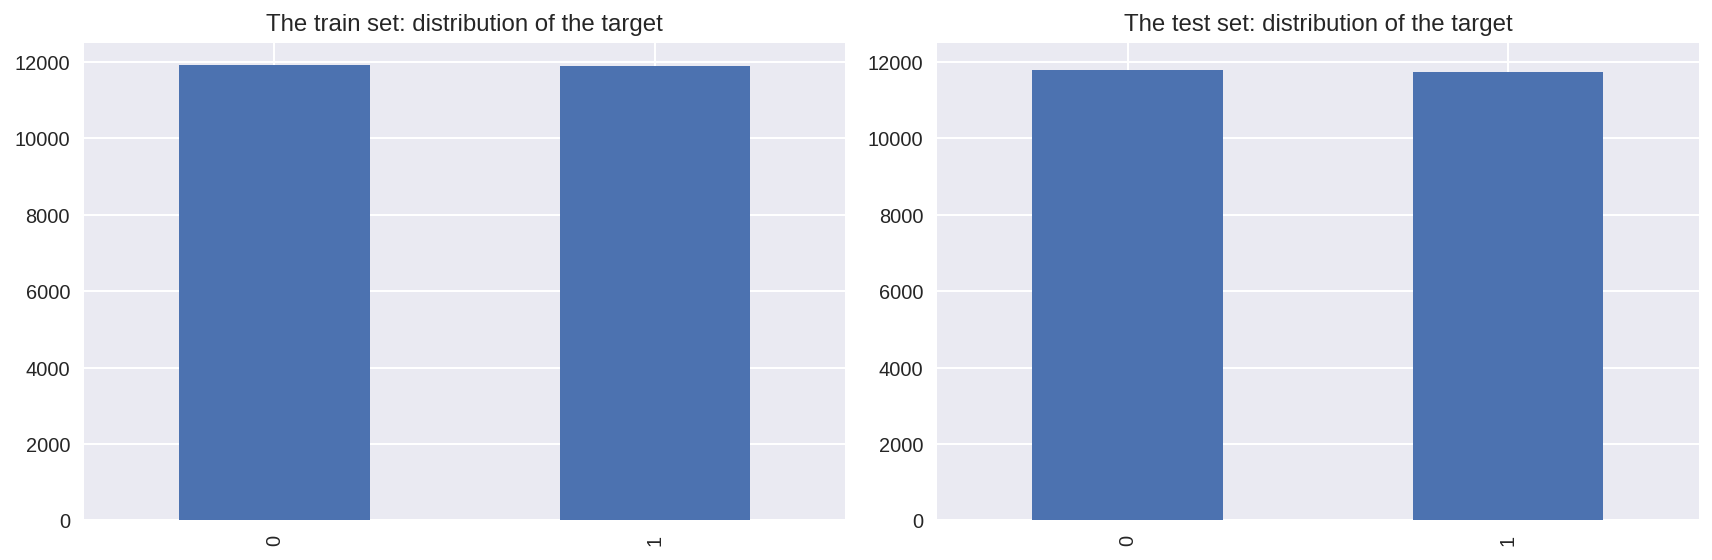

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
balance = df_reviews.query('ds_part == "train"')['pos'].value_counts().sort_index()
balance.plot.bar(ax=ax)
ax.set_ylim([0, 12500])
ax.set_title('The train set: distribution of the target')

ax = axs[1]
balance = df_reviews.query('ds_part == "test"')['pos'].value_counts().sort_index()
balance.plot.bar(ax=ax)
ax.set_ylim([0, 12500])
ax.set_title('The test set: distribution of the target')

fig.tight_layout()

<b style="font-size: 20px;">Intermediate conclusion:</b>

Our Target is balanced

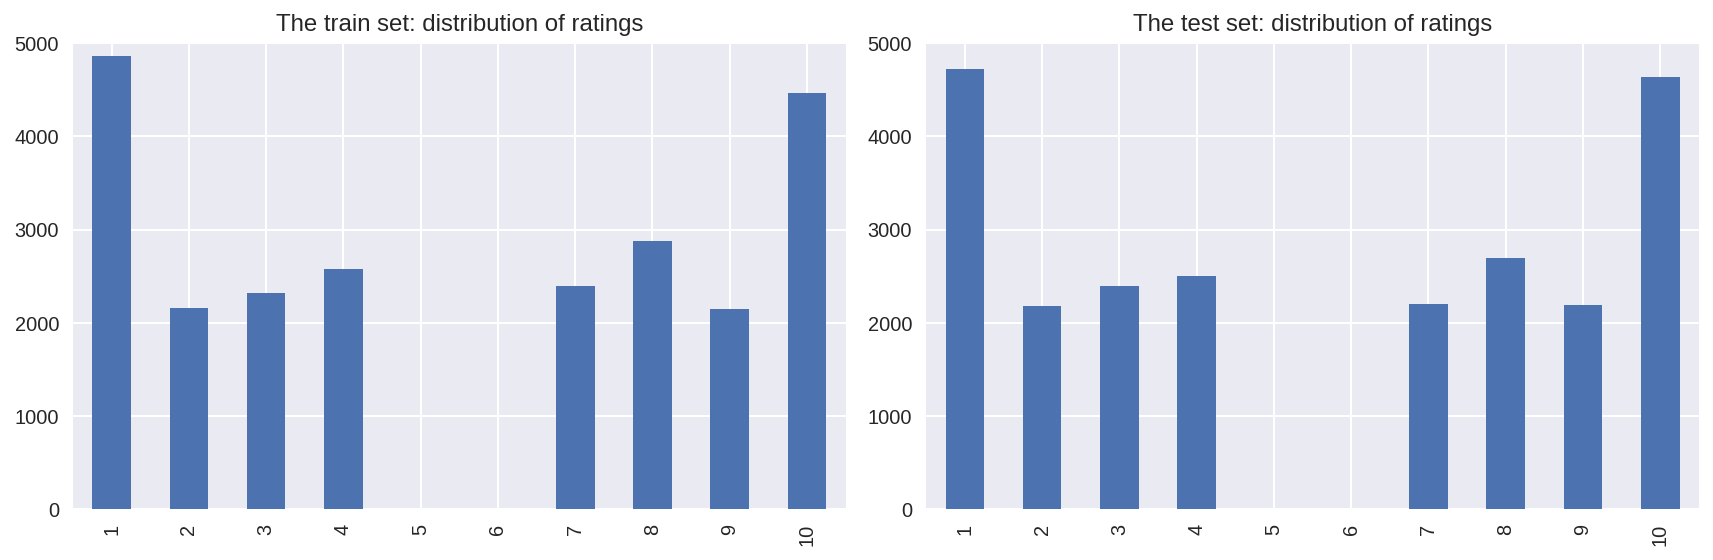

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In [16]:
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
print('Training set:')
print(dft)
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
print()
print('Testing set:')
print(dft)

Training set:
1     4863
2     2155
3     2317
4     2577
7     2393
8     2876
9     2153
10    4462
Name: rating, dtype: int64

Testing set:
1     4726
2     2184
3     2392
4     2501
7     2200
8     2700
9     2189
10    4641
Name: rating, dtype: int64


<b style="font-size: 20px;">Intermediate conclusion:</b>

We can see that our distribution rating is similar in both sets 'Train' and 'Test', as we can tell 4 and lower than that is negative review when 7 and higher is positive one, when also can see that no rating review in the middle 5-6.

Distribution of negative and positive reviews over the years for two parts of the dataset

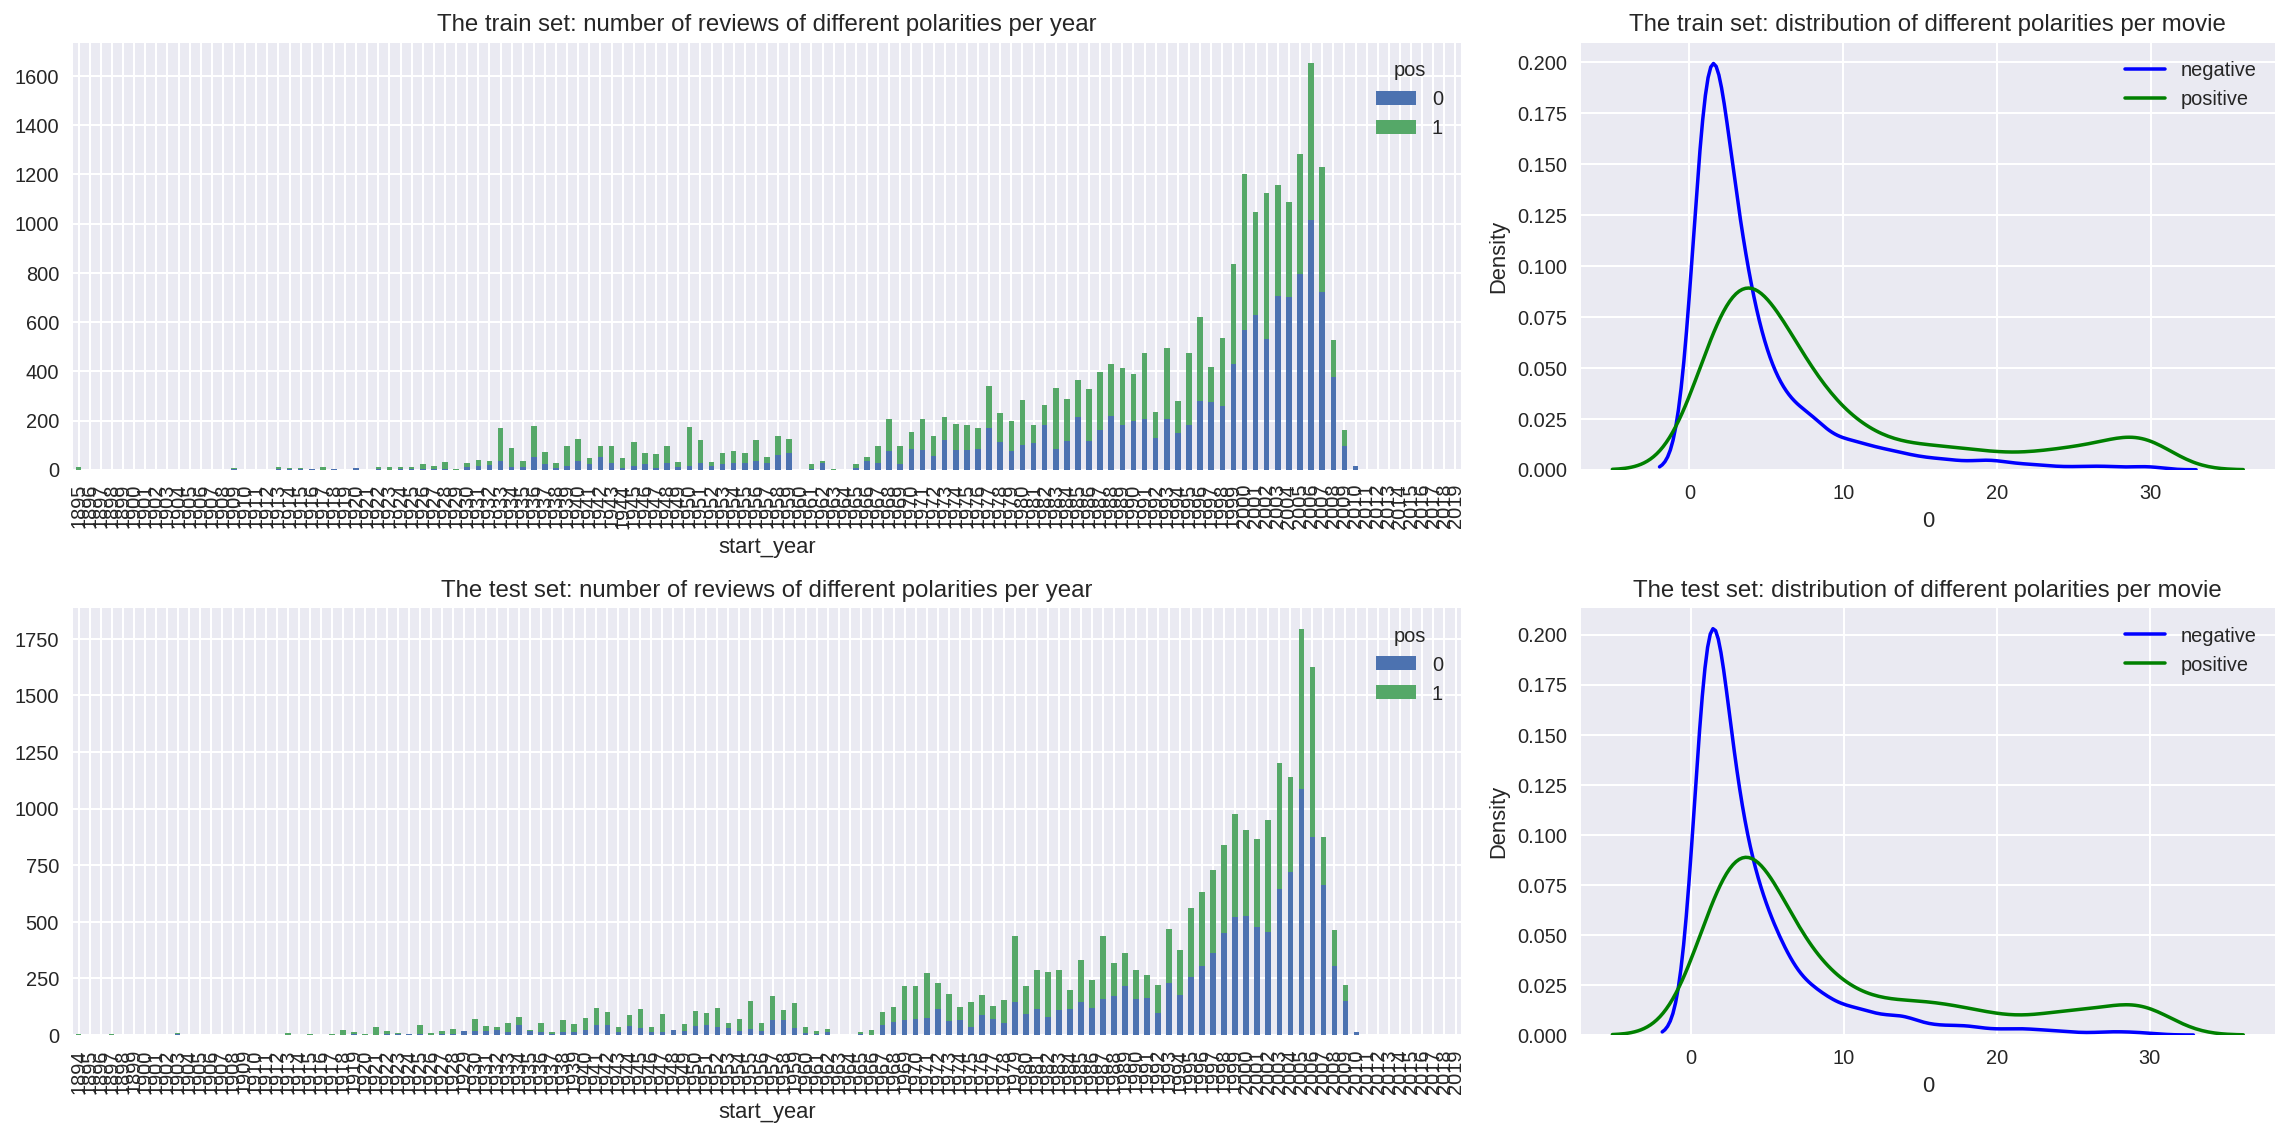

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<b style="font-size: 20px;">Intermediate conclusion:</b>

We can see that our reviews balanced per year and they distrbuted the same in both 'Train' and Test' sets. When newer movies got more review than old one.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [18]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [19]:
import re
def clear_text(text):
    pattern = r"[^a-zA-Z]"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text)
    text = text.lower()
    return text 

In [20]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

In [21]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in sing...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,i m totally agree with garryjohal from singapo...


In [22]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [23]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_features = df_reviews_train['review_norm']
test_features  = df_reviews_test['review_norm']

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

In [24]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


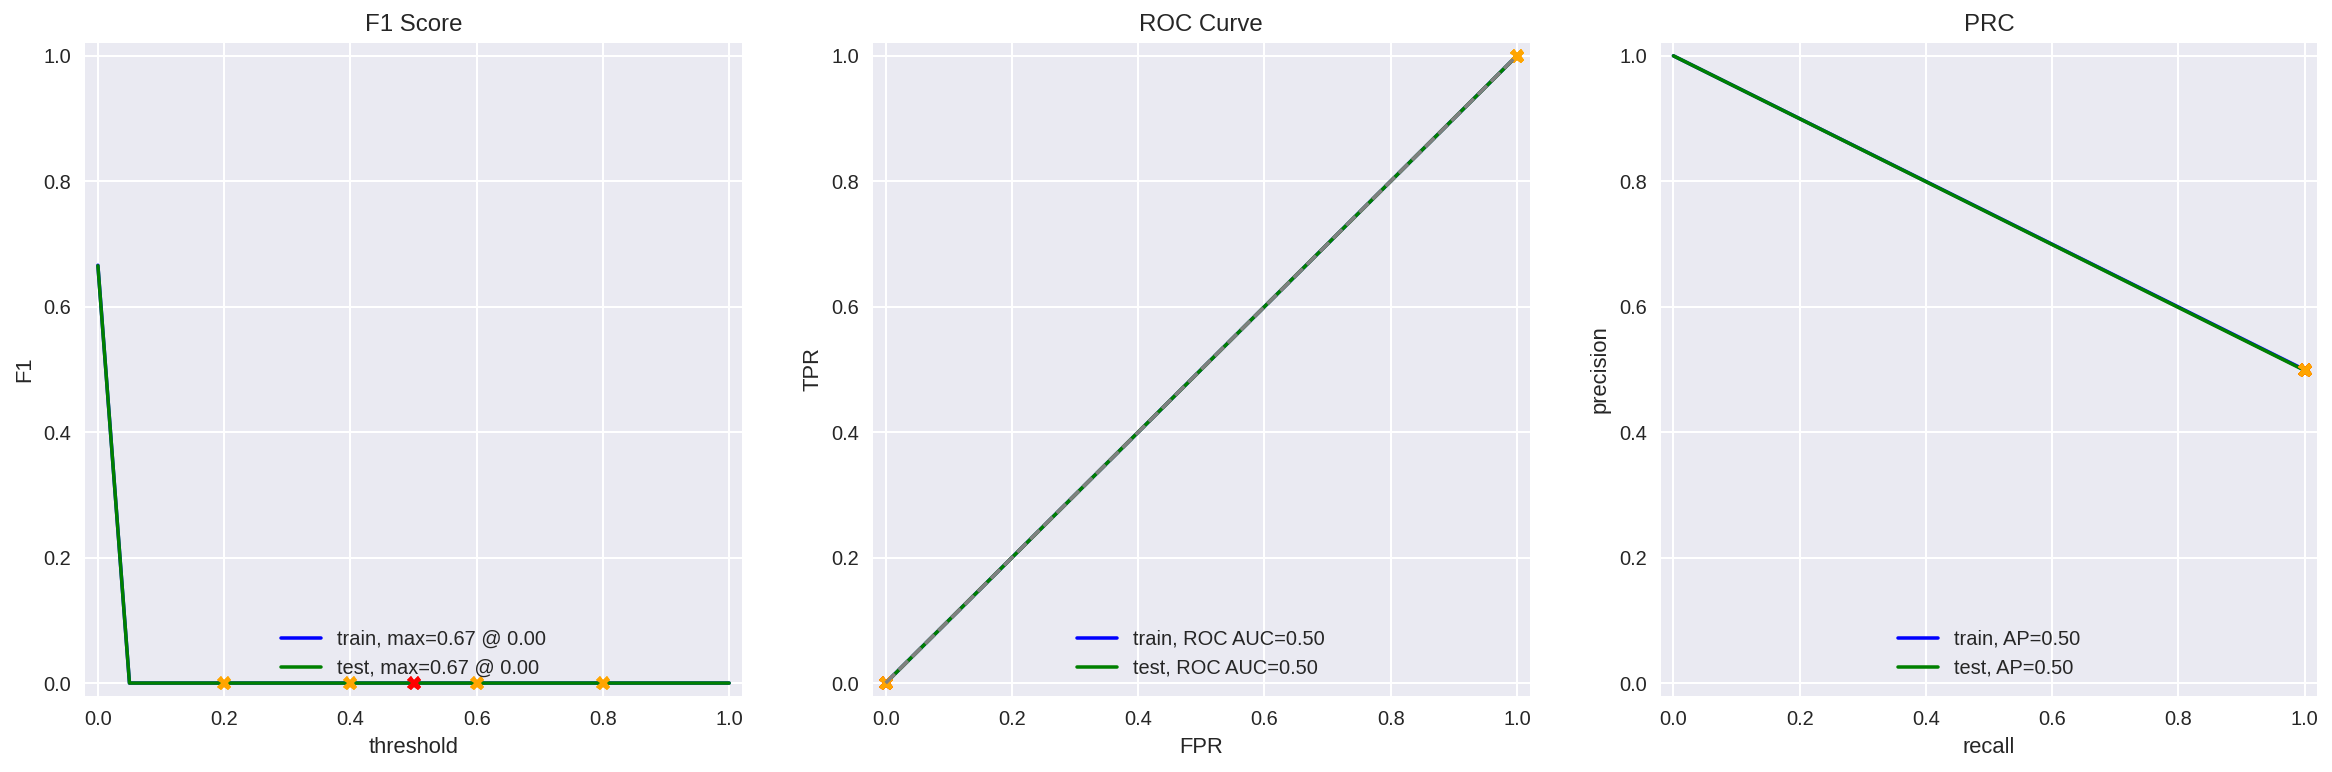

In [25]:
model_0 = DummyClassifier(strategy="constant", random_state=12345,constant=[0])
model_0.fit(train_features, train_target)
predictions = model_0.predict(test_features)

evaluate_model(model_0, train_features, train_target, test_features, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [26]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [27]:
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

stop_words = set(stopwords.words('english'))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words) 
train_features_1 =  tfidf_vectorizer_1.fit_transform(corpus_train)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


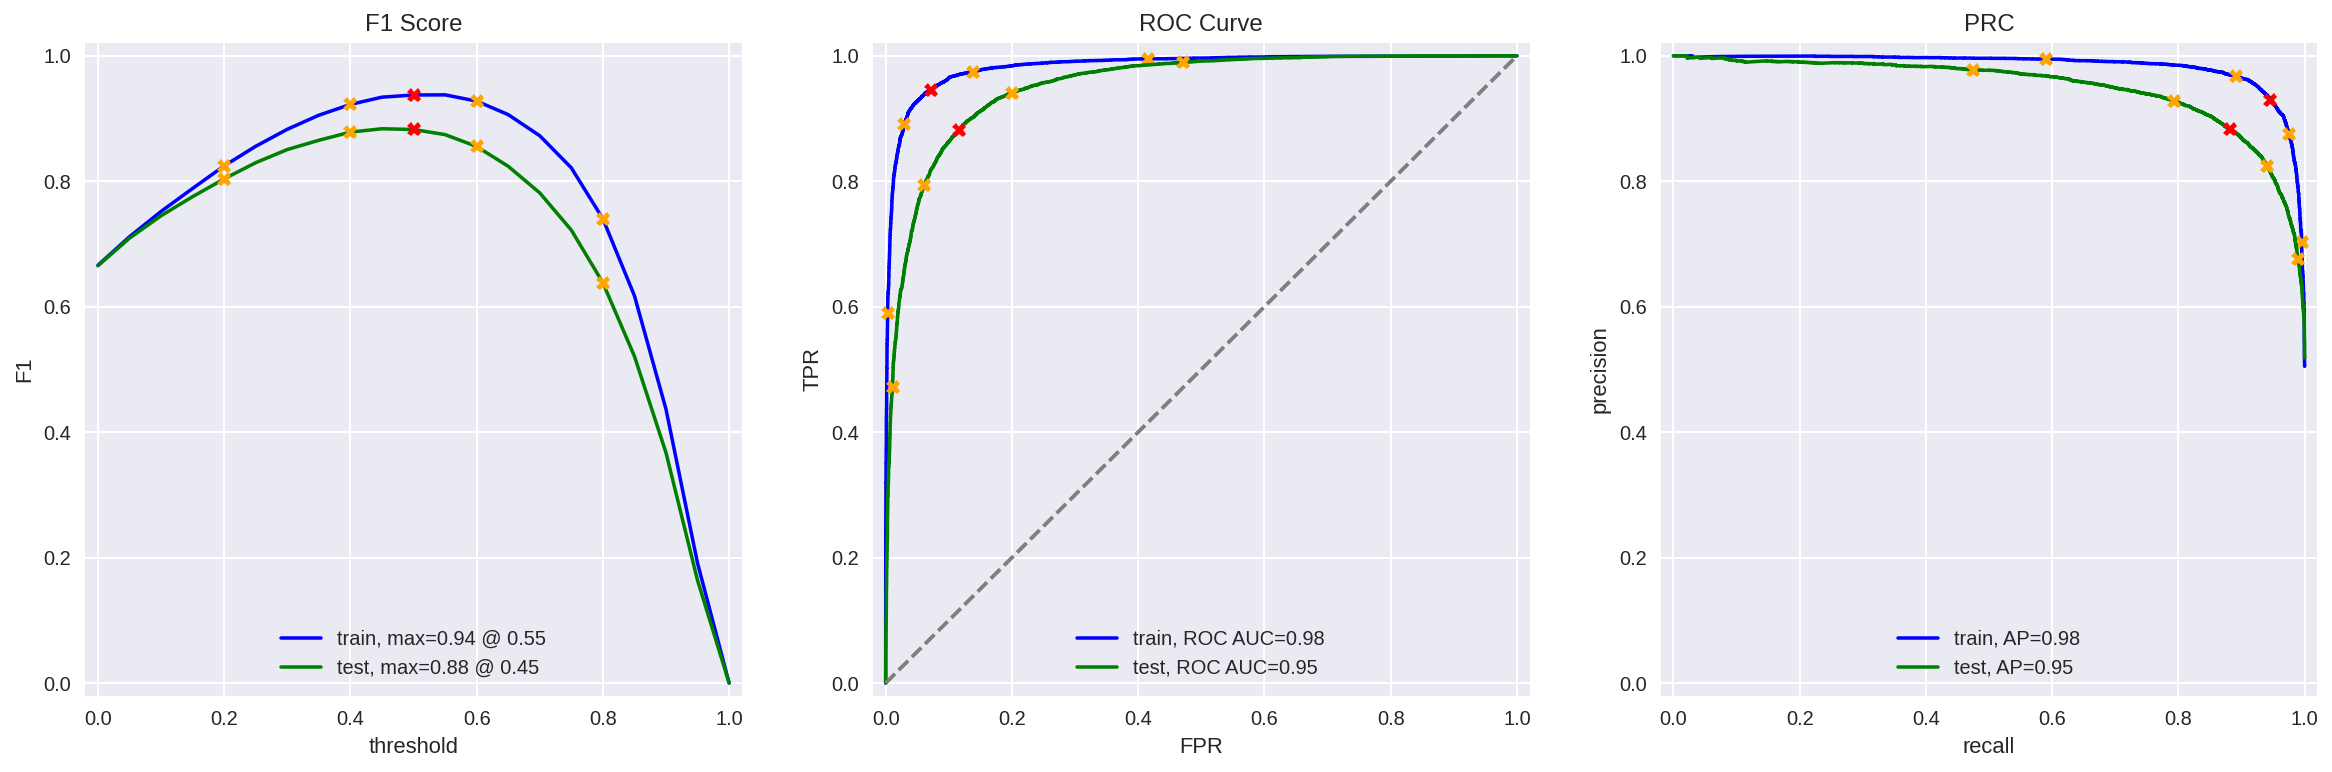

In [28]:
model_1 = LogisticRegression(solver='liblinear',random_state=12345)
model_1.fit(train_features_1, train_target)

test_features_1 =  tfidf_vectorizer_1.transform(corpus_test)
predictions = model_1.predict(test_features_1)

evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [29]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [31]:
df_reviews['review_lemm'] = df_reviews['review_norm'].apply(text_preprocessing_3)

In [32]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

corpus_train = df_reviews_train['review_lemm']
corpus_test = df_reviews_test['review_lemm']

stop_words = set(stopwords.words('english'))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words) 
train_features_3 =  tfidf_vectorizer_3.fit_transform(corpus_train)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


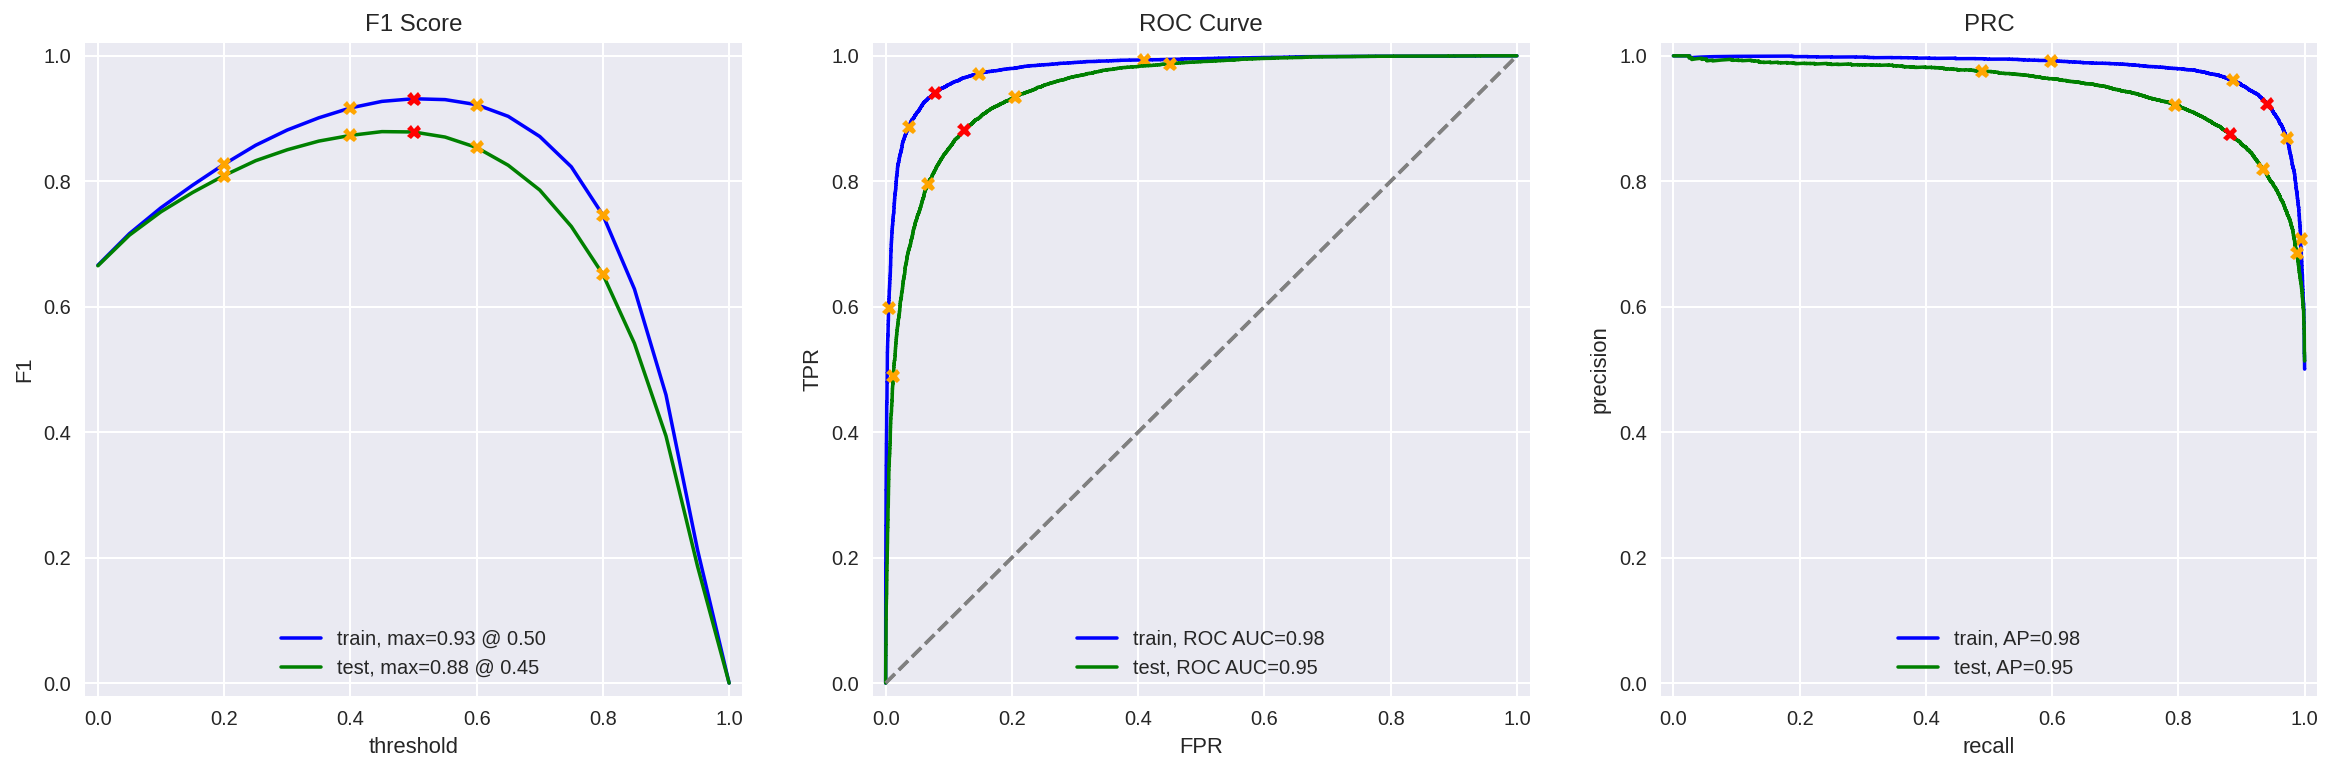

In [33]:
model_3 = LogisticRegression(solver='liblinear',random_state=12345)
model_3.fit(train_features_3, train_target)

test_features_3 =  tfidf_vectorizer_3.transform(corpus_test)
predictions = model_3.predict(test_features_3)

evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [34]:
from lightgbm import LGBMClassifier

In [35]:
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words) 
train_features_4 =  tfidf_vectorizer_4.fit_transform(corpus_train)

          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


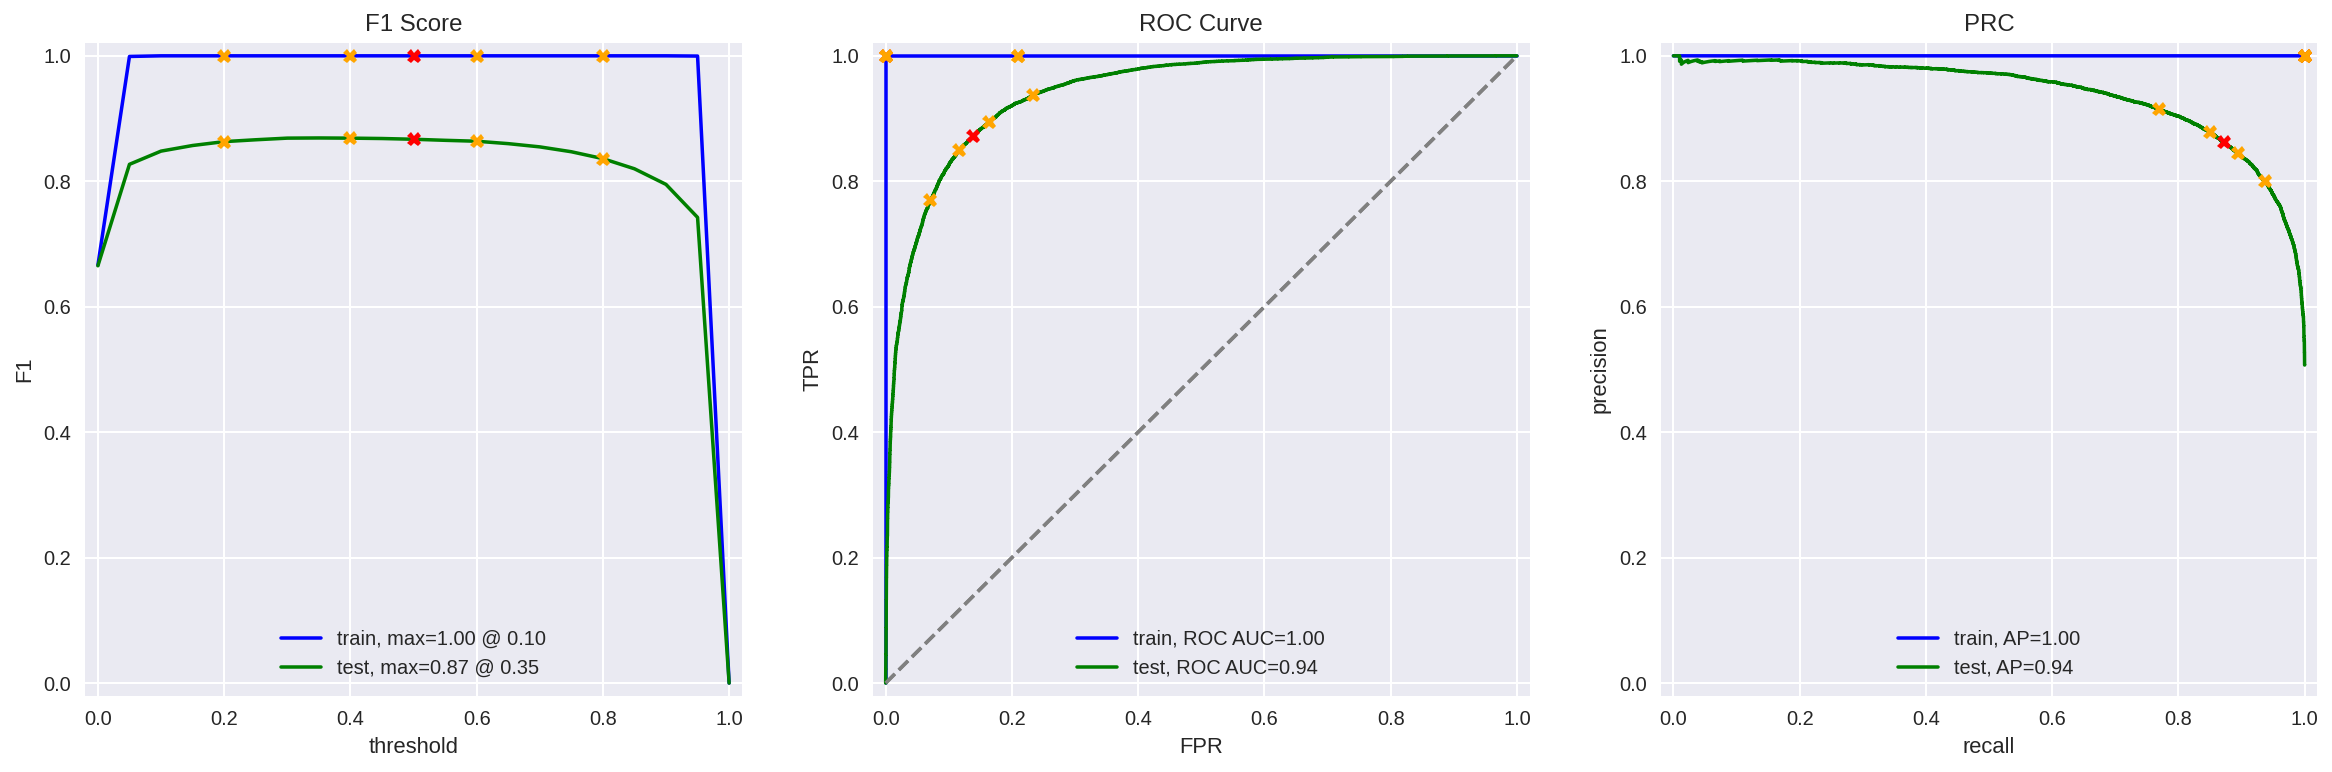

In [36]:
#after testing we decied to go with this parameters of LGBM
model_4 = LGBMClassifier(task = 'predict', num_iterations = 180 ,num_leaves = 210 , max_depth = 180)
model_4.fit(train_features_4, train_target)

test_features_4 =  tfidf_vectorizer_4.transform(corpus_test)
predictions = model_4.predict(test_features_4)

evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Model 9 - BERT

In [37]:
import torch
import transformers

In [39]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=10, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    max_sample_size = 200

    
    for input_text in df_reviews.iloc[:max_sample_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [41]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu')

Using the cpu device.


  0%|          | 0/20 [00:00<?, ?it/s]

In [42]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(200, 768)
(23796,)


In [43]:
max_sample_size = 200
features = train_features_9
target = df_reviews.iloc[:max_sample_size]['pos']

print(features.shape)
print(target.shape)

(200, 768)
(200,)


In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=42) 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 768)
(100, 768)
(100,)
(100,)


In [45]:
# train and test your model
model_9 = LogisticRegression(solver='liblinear',random_state=12345)
model_9.fit(X_train,y_train)
model_9.predict(X_test)

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1])

          train  test
Accuracy    1.0  0.89
F1          1.0  0.91
APS         1.0  0.98
ROC AUC     1.0  0.97


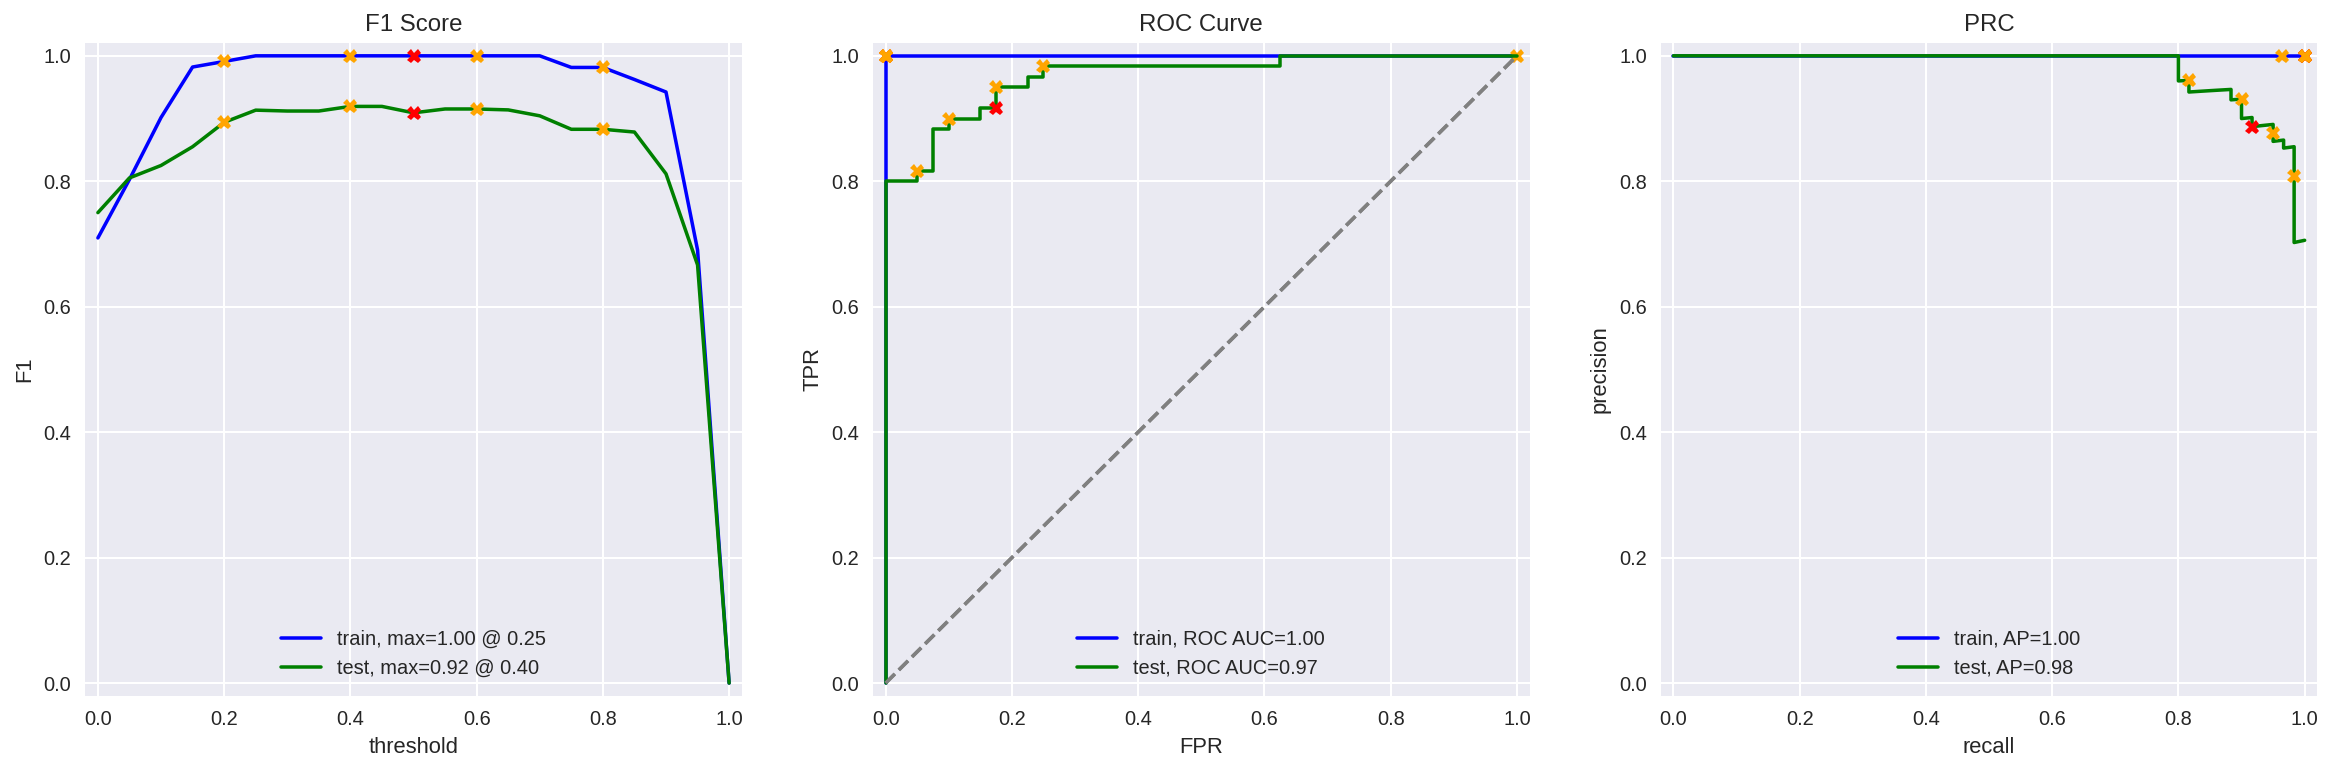

In [46]:
evaluate_model(model_9, X_train, y_train, X_test, y_test)

In [47]:
# saving embeddings
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [48]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

the_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'The movie was hilarious, the actors made me laugh from start to finish of the play',
    'Bad storyline, bad acting, I was really horrified, worst film ever made.',
    "It would be a shame to don't see this movie.",
    'Anyone who is ever watched Sophie Turner on "Game of Thrones" should know that she cannot carry a movie. She is lovely, but has one expression.',
    'A sophomorically conceived film that tries to push every cliched button of the politically correct lunatics that fuel modern Hollywood philosophies. A film that gets into so many false premises that it should have been a black comedy had the filmmakers had the intellectual maturity to satirize such immature writing. Yuk.',
    'What a turkey! A dried up, emaciated and leathery old turkey not even worth cooking. Should have been left for the buzzards. When Pierce Brosnan uttered the zinger when conducting the initial examination, I thought, no way. If this was the premise, why a ham-fisted line like that. Against my better judgement I persisted. Silly me.',
    'what an awful movie',
    'loved it so much',
    'These historical embroideries -- as well as an appealing, diverse cast -- might make for splendid cinema if only they weren’t trapped in a confused story line that starts as a revenge scheme before veering into romance.',  
    'Mr. Malcolm’s List is a delightful blend of modern romantic comedy and Jane Austen-esque nostalgia.'], columns=['review'])

the_reviews['review_norm'] = the_reviews['review_norm'] = the_reviews['review'].apply(clear_text)# <put here the same normalization logic as for the main dataset>

the_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...
8,"The movie was hilarious, the actors made me la...",the movie was hilarious the actors made me lau...
9,"Bad storyline, bad acting, I was really horrif...",bad storyline bad acting i was really horrifie...


### Model 1

In [49]:
texts = the_reviews['review_norm']

the_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{the_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.63:  the movie was hilarious the actors made me laugh from start to finish of the play
0.00:  bad storyline bad acting i was really horrified worst film ever made
0.20:  it would be a shame to don t see this movie
0.59:  anyone who is ever watched sophie turner on game of thrones should know that she can

### Model 3

In [50]:
texts = the_reviews['review_norm']

the_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{the_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.64:  the movie was hilarious the actors made me laugh from start to finish of the play
0.00:  bad storyline bad acting i was really horrified worst film ever made
0.19:  it would be a shame to don t see this movie
0.78:  anyone who is ever watched sophie turner on game of thrones should know that she can

### Model 4

In [51]:
texts = the_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3

the_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{the_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  i did not simply like it not my kind of movie
0.09:  well i was bored and felt asleep in the middle of the movie
0.79:  i was really fascinated with the movie
0.02:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.22:  i didn t expect the reboot to be so good writers really cared about the source material
0.92:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1.00:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.84:  the movie was hilarious the actors made me laugh from start to finish of the play
0.00:  bad storyline bad acting i was really horrified worst film ever made
0.50:  it would be a shame to don t see this movie
0.99:  anyone who is ever watched sophie turner on game of thrones should know that she can

### Model 9

In [52]:
texts = the_reviews['review_norm']

the_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

the_reviews_pred_prob = model_9.predict_proba(the_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{the_reviews_pred_prob[i]:.2f}:  {review}')

0.01:  i did not simply like it not my kind of movie
0.05:  well i was bored and felt asleep in the middle of the movie
0.18:  i was really fascinated with the movie
0.99:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.98:  i didn t expect the reboot to be so good writers really cared about the source material
1.00:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.93:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.13:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.05:  the movie was hilarious the actors made me laugh from start to finish of the play
0.36:  bad storyline bad acting i was really horrified worst film ever made
0.14:  it would be a shame to don t see this movie
0.05:  anyone who is ever watched sophie turner on game of thrones should know that she can

## Conclusions

After we load our data , we check if and learn the basic also we found there isn't any duplicated rows and we have only few missing values which we drop in the right way after we see it.

We examined with EDA the distribution and also deciphered the information regarding the cross-section of the reviews and the ratings index of the films the progress with in years and found that newer movies had more reviews than old ones and that since the 2007 financial crisis may effect this industry years later and we see less and less reviews since less movies made. also we found that our data is balance and we found that it's almost 50:50

In our next chapter after split our data we start to build and test our models in point to get at least 0.85 in F1 scores here is the results:


<h2><center>Summary results F1 Score vs different models</center></h2>

| Model No. | Model | Train | Test |
|:-------|-------|-------|-------|
| 1 |  NLTK, TF-IDF & LR    | 0.94 | 0.88 |
| 3 |  spaCy,TF-IDF & LR    | 0.93 | 0.88 | 
| 4 |  spaCy,TF-IDF & LGBM  |  1.0 | 0.87 |
| 9 |  BERT obtained F1     |  1.0 | 0.91 | 

All our models reach our goal of at least 0.85 in the f1 score as we can see in the table score above. important to say that at first we use 'cuda' to calc BERT in our local computer and everything works fine, but when we try it in the server to see that everything work we get error no Nvidia driver found so we change it to cpu and after many issues of died kernal, We lower the batch size from '100' to '10' and limit the data we check to only 200 rows.

Although we got our "the reviews" classified one of the reviews as negative while it was positive , BERT done amazing job even if it's not 100% of prefection, it's very very close. 

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions